<a href="https://colab.research.google.com/github/AyalYakobe/Covid19OutcomesAndVaccineBehaviorByCounty/blob/main/Copy_of_STATS_4241_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STATS-4241 PART 2

## Imports and technicals

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import parallel_backend

import umap.umap_ as umap

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, r

## Loads

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/STATS-4241/merged_df_reduced.csv"

string_cols = [
    'state', 'county', 'county_score', 'svi_category', 'cvac_level_of_concern',
    'geographical_point', 'county_boundary', 'state_boundary',
    'per_capita_exp_esrd', 'avg_risk_score_esrd', 'avg_demog_score_esrd', 'person_years_esrd',
    'per_capita_exp_dis', 'avg_risk_score_dis', 'avg_demog_score_dis', 'person_years_dis',
    'per_capita_exp_agdu', 'avg_risk_score_agdu', 'avg_demog_score_agdu', 'person_years_agdu',
    'per_capita_exp_agnd', 'avg_risk_score_agnd', 'avg_demog_score_agnd', 'person_years_agnd'
]

dtype_spec = {col: str for col in string_cols}

merged_df = pd.read_csv(file_path, dtype=dtype_spec, low_memory=False)
merged_df

,state,county,age_0_4,age_5_19,age_20_49,age_50_64,age_65_,tot_male,tot_female,tot_white,...,avg_risk_score_agnd,avg_demog_score_agnd,person_years_agnd,cumulative_deaths_per_100k,cumulative_cases_per_100k,new_cases_per_100k,new_deaths_per_100k,pop_density,mortality_per_100k,mortality_rate_cfr
0,ALABAMA,AUTAUGA,3504,11740,22753,11632,9286,28760,30155,45649,...,1.02651,1.01859,3150.17,81.473309,7067.809556,7067.809556,81.473309,99.183502,81.473309,1.152738
1,ALABAMA,AUTAUGA,3441,11775,22772,11736,9479,28782,30421,45633,...,1.02369,1.0249,3000.33,270.256575,18387.581710,11354.154350,189.179602,99.668350,270.256575,1.469778
2,ALABAMA,AUTAUGA,3463,11835,22769,11897,9762,29030,30696,45851,...,1.03108,1.03871,2932.17,385.091920,31746.643003,13520.075009,117.201889,100.548822,385.091920,1.213016
3,ALABAMA,AUTAUGA,3617,11775,22841,11982,10127,29277,31065,46141,...,1.07466,1.06244,2721.42,389.446820,33000.232011,1577.673925,8.286103,101.585859,389.446820,1.180134
4,ALABAMA,BALDWIN,12241,42749,80047,49137,49053,113911,119316,208034,...,1.0032,1.00088,19521.33,68.602692,5742.045304,5742.045304,68.602692,146.775960,68.602692,1.194743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11699,WYOMING,WASHAKIE,341,1397,2537,1543,1892,3977,3733,7447,...,0.83926,1.02342,1099,661.478599,34267.185473,583.657588,51.880674,3.441964,661.478599,1.930356
11700,WYOMING,WESTON,309,1164,2397,1487,1459,3712,3104,6504,...,0.86251,0.99737,907.92,29.342723,6954.225352,6954.225352,29.342723,2.842369,29.342723,0.421941
11701,WYOMING,WESTON,295,1162,2350,1464,1475,3700,3046,6429,...,0.88311,0.98311,924.83,207.530388,18692.558553,11666.172547,177.883190,2.813178,207.530388,1.110230
11702,WYOMING,WESTON,285,1158,2405,1460,1550,3776,3082,6548,...,0.87757,0.98836,950.67,320.793234,27413.240012,9025.955089,116.652085,2.859883,320.793234,1.170213


In [ ]:

# create new variables
merged_df["mortality_per_100k"] = (
    merged_df["cumulative_deaths"] / merged_df["tot_pop"]
) * 100000

merged_df["mortality_rate_cfr"] = (
    merged_df["cumulative_deaths"] / merged_df["cumulative_cases"]
) * 100

merged_df["county_score"] = pd.to_numeric(merged_df["county_score"], errors="coerce")
merged_df["rep_leaning"] = (merged_df["county_score"] < 0).astype(int)
merged_df["party_strength"] = merged_df["county_score"].abs()



## Supervised approaches

### Lasso

Baseline code: loop across outcome variables

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define outcome and explanatory variables
outcome_vars = [
    "estimated_hesitant",
    "cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]


explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    #"tot_pop", "area",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    #"county_score",
    "rep_leaning", "party_strength", # political
    "poverty_rate", "social_vulnerability_index_svi",  # socio-economic
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",  # health
    "new_cases_per_100k",
]


# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Step 1: Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    # Step 2: Coerce all columns to numeric
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Step 3: Drop rows with missing values
    df = df.dropna()

    # Step 4: Check for outcome variation
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Step 5: Split into X and y
    X = df[explanatory_vars]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)

    y = df[current_y]

    # Step 6: Standardize predictors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 7: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Step 8: Fit Lasso on training data
    lasso = LassoCV(cv=5, alphas=np.logspace(-6, 2, 200), random_state=42)
    lasso.fit(X_train, y_train)

    # Step 9: Evaluate test performance
    y_pred_test = lasso.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Step 10: Collect non-zero coefficients
    coefs = pd.Series(lasso.coef_, index=X.columns)
    important = coefs[coefs != 0].sort_values(key=abs, ascending=False)

    # Step 11: Display results
    print(f"Optimal alpha: {lasso.alpha_:.4f}")
    print(f"Training R² score: {r2_score(y_train, lasso.predict(X_train)):.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")
    print("Selected predictors:")
    print(important, "\n")

zero_coef_vars = X.columns[lasso.coef_ == 0]
print("Variables dropped by Lasso (coef = 0):")
print(zero_coef_vars.tolist())

nonzero_coef_vars = X.columns[lasso.coef_ != 0]
print("Variables kept by Lasso:")
print(nonzero_coef_vars.tolist())





Analyzing outcome: estimated_hesitant
Optimal alpha: 0.0034
Training R² score: 0.430
Test R² score    : 0.405
Test MSE         : 11.95
Selected predictors:
person_years_dis                 -1.744516e+00
tot_hisp_share                   -1.604784e+00
tot_asian_share                  -1.163138e+00
poverty_rate                      1.021078e+00
person_years_agnd                 7.971889e-01
social_vulnerability_index_svi    7.750856e-01
age_0_4_share                     6.506693e-01
person_years_esrd                 6.421327e-01
party_strength                    5.676531e-01
new_cases_per_100k                3.964878e-01
tot_native_share                  3.956706e-01
age_65__share                    -3.927084e-01
person_years_agdu                 2.836640e-01
tot_black_share                  -2.500728e-01
pop_density                      -2.402944e-01
year_2022                        -1.876944e-01
year_2023                         1.562287e-01
rep_leaning                       1.467247e-0

#### Futher exploration: adding interaction explicitly

We add an interaction (party*strength) to see whether the effect of party strength differs by party

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define outcome and explanatory variables
outcome_vars = [
    "estimated_hesitant",
    "cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]


explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    #"tot_pop", "area",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    #"county_score",
    "rep_leaning", "party_strength", # political
    "poverty_rate", "social_vulnerability_index_svi",  # socio-economic
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",  # health
    "new_cases_per_100k",
]


# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Step 1: Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    # Step 2: Coerce all columns to numeric
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Step 3: Drop rows with missing values
    df = df.dropna()

    # Step 4: Check for outcome variation
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Step 5: Split into X and y
    X = df[explanatory_vars]
    X["rep_strength_interaction"] = X["rep_leaning"] * X["party_strength"]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)

    y = df[current_y]

    # Step 6: Standardize predictors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 7: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Step 8: Fit Lasso on training data
    lasso = LassoCV(cv=5, alphas=np.logspace(-6, 2, 200), random_state=42)
    lasso.fit(X_train, y_train)

    # Step 9: Evaluate test performance
    y_pred_test = lasso.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Step 10: Collect non-zero coefficients
    coefs = pd.Series(lasso.coef_, index=X.columns)
    important = coefs[coefs != 0].sort_values(key=abs, ascending=False)

    # Step 11: Display results
    print(f"Optimal alpha: {lasso.alpha_:.4f}")
    print(f"Training R² score: {r2_score(y_train, lasso.predict(X_train)):.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")
    print("Selected predictors:")
    print(important, "\n")


zero_coef_vars = X.columns[lasso.coef_ == 0]
print("Variables dropped by Lasso (coef = 0):")
print(zero_coef_vars.tolist())

nonzero_coef_vars = X.columns[lasso.coef_ != 0]
print("Variables kept by Lasso:")
print(nonzero_coef_vars.tolist())



Analyzing outcome: estimated_hesitant
Optimal alpha: 0.0031
Training R² score: 0.430
Test R² score    : 0.405
Test MSE         : 11.95
Selected predictors:
person_years_dis                 -1.753933e+00
tot_hisp_share                   -1.602948e+00
tot_asian_share                  -1.165849e+00
poverty_rate                      1.022578e+00
person_years_agnd                 8.033027e-01
social_vulnerability_index_svi    7.758765e-01
age_0_4_share                     6.493701e-01
person_years_esrd                 6.404778e-01
party_strength                    5.448401e-01
tot_native_share                  3.979771e-01
new_cases_per_100k                3.949256e-01
age_65__share                    -3.930032e-01
person_years_agdu                 2.881301e-01
pop_density                      -2.409724e-01
tot_black_share                  -2.400564e-01
year_2022                        -1.874012e-01
year_2023                         1.549743e-01
tot_white_share                   1.206736e-0

We add an interaction (party*year) to see whether the effect of party representation differs by year

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define your outcome and explanatory variables
outcome_vars = [
    #"estimated_hesitant",
    #"cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]


explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    #"tot_pop", "area",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    #"county_score",
    "rep_leaning", "party_strength", # political
    "poverty_rate", "social_vulnerability_index_svi",  # socio-economic
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",  # health
    "new_cases_per_100k",
]


# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Step 1: Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    # Step 2: Coerce all columns to numeric
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Step 3: Drop rows with missing values
    df = df.dropna()

    # Step 4: Check for outcome variation
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Step 5: Split into X and y
    X = df[explanatory_vars]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)

    for col in X.columns:
      if col.startswith("year_"):
        X[f"rep_leaning_{col}"] = X["rep_leaning"] * X[col]


    y = df[current_y]

    # Step 6: Standardize predictors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 7: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Step 8: Fit Lasso on training data
    lasso = LassoCV(cv=5, alphas=np.logspace(-6, 2, 200), random_state=42)
    lasso.fit(X_train, y_train)

    # Step 9: Evaluate test performance
    y_pred_test = lasso.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Step 10: Collect non-zero coefficients
    coefs = pd.Series(lasso.coef_, index=X.columns)
    important = coefs[coefs != 0].sort_values(key=abs, ascending=False)

    # Step 11: Display results
    print(f"Optimal alpha: {lasso.alpha_:.4f}")
    print(f"Training R² score: {r2_score(y_train, lasso.predict(X_train)):.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")
    print("Selected predictors:")
    print(important, "\n")


zero_coef_vars = X.columns[lasso.coef_ == 0]
print("Variables dropped by Lasso (coef = 0):")
print(zero_coef_vars.tolist())

nonzero_coef_vars = X.columns[lasso.coef_ != 0]
print("Variables kept by Lasso:")
print(nonzero_coef_vars.tolist())



Analyzing outcome: series_complete_pop_pct
Optimal alpha: 0.0022
Training R² score: 0.891
Test R² score    : 0.891
Test MSE         : 75.70
Selected predictors:
year_2023                         23.347670
year_2022                         21.795372
year_2021                         19.754695
tot_white_share                   -6.644762
tot_black_share                   -4.381062
person_years_esrd                 -4.140403
tot_hisp_share                     3.735617
social_vulnerability_index_svi    -3.476356
person_years_dis                   3.030875
new_cases_per_100k                 2.167765
age_5_19_share                    -1.934542
tot_male_share                    -1.344068
person_years_agnd                  1.295056
age_0_4_share                     -1.278040
age_50_64_share                   -1.257570
tot_asian_share                    1.024365
party_strength                    -0.969872
rep_leaning_year_2021              0.802881
rep_leaning_year_2023              0.620913
per

### Random forest

With Feature Importance Plot

a. 10 most important features

b. 10 most important features excluding year dummies: intuitively, "year" is a very important determinant of Covid outcomes, which makes it hard to interpret the relative importance of the rest.

Analyzing outcome: estimated_hesitant
Training R² score: 0.982
Test R² score    : 0.880
Test MSE         : 2.41
Top 10 features by permutation importance:
poverty_rate                      0.493825
tot_hisp_share                    0.249443
age_0_4_share                     0.174472
person_years_agdu                 0.123766
age_5_19_share                    0.119219
party_strength                    0.108702
tot_black_share                   0.106845
tot_asian_share                   0.097374
pop_density                       0.089736
social_vulnerability_index_svi    0.062212
dtype: float64 



/tmp/ipython-input-8-812994265.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


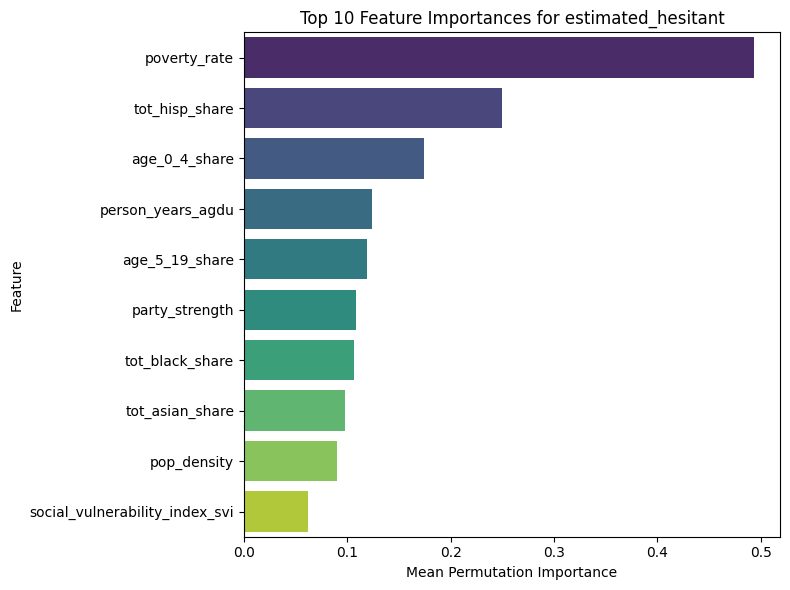

/tmp/ipython-input-8-812994265.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


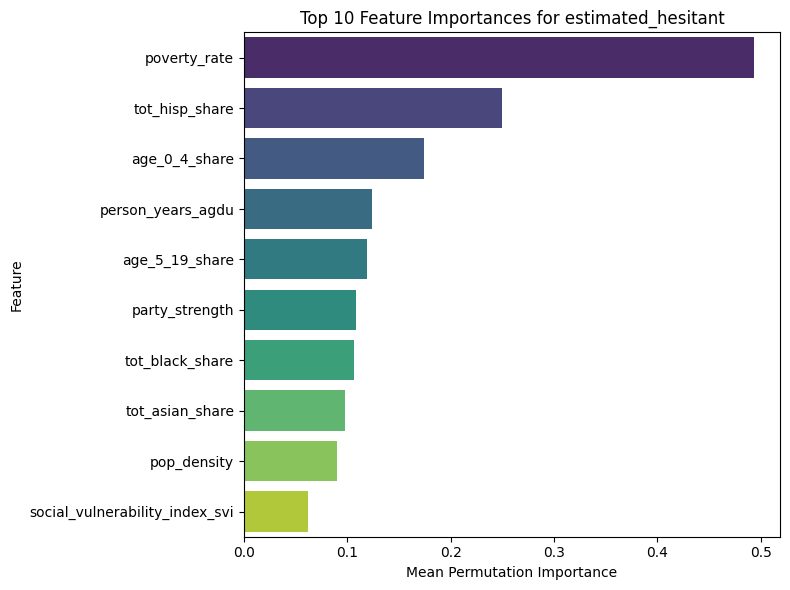

Analyzing outcome: cvac_level_of_concern_for_vaccination_rollout
Training R² score: 0.988
Test R² score    : 0.917
Test MSE         : 69.95
Top 10 features by permutation importance:
social_vulnerability_index_svi    0.761132
person_years_dis                  0.114823
poverty_rate                      0.103525
tot_hisp_share                    0.090959
party_strength                    0.068597
pop_density                       0.061817
tot_black_share                   0.047183
person_years_agnd                 0.036133
tot_white_share                   0.035947
tot_asian_share                   0.033484
dtype: float64 



/tmp/ipython-input-8-812994265.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


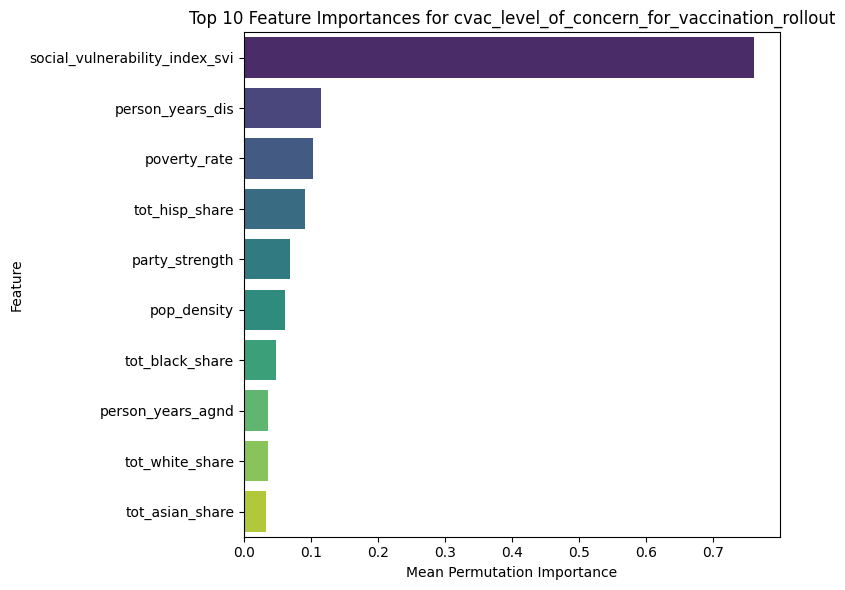

/tmp/ipython-input-8-812994265.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


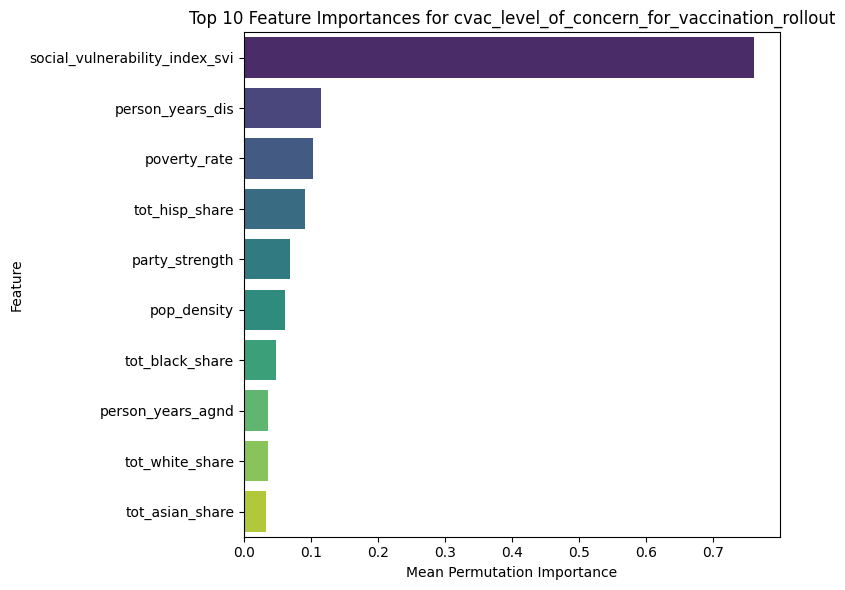

Analyzing outcome: series_complete_pop_pct
Training R² score: 0.989
Test R² score    : 0.931
Test MSE         : 47.59
Top 10 features by permutation importance:
year_2023                         1.145237
year_2022                         1.067412
year_2021                         0.895914
person_years_agdu                 0.038187
tot_asian_share                   0.016856
new_cases_per_100k                0.012811
poverty_rate                      0.010792
party_strength                    0.007858
age_0_4_share                     0.006745
social_vulnerability_index_svi    0.006057
dtype: float64 



/tmp/ipython-input-8-812994265.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


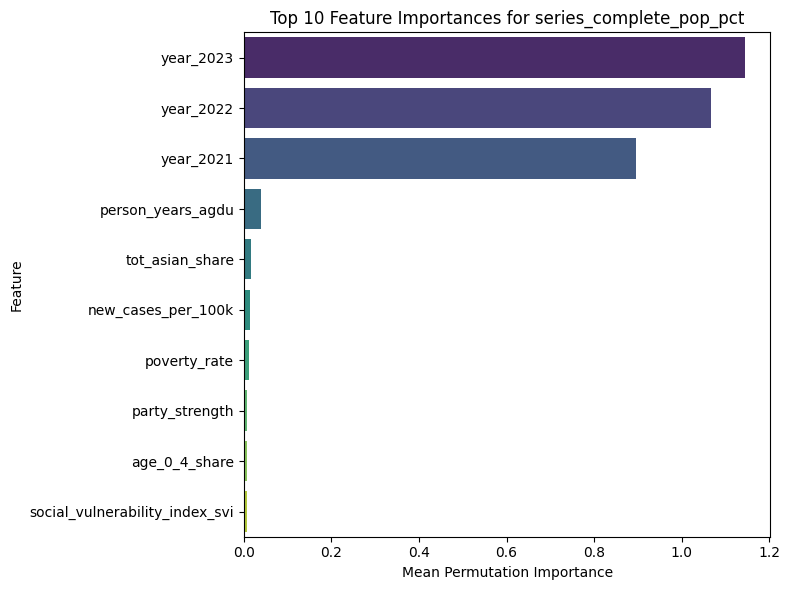

/tmp/ipython-input-8-812994265.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


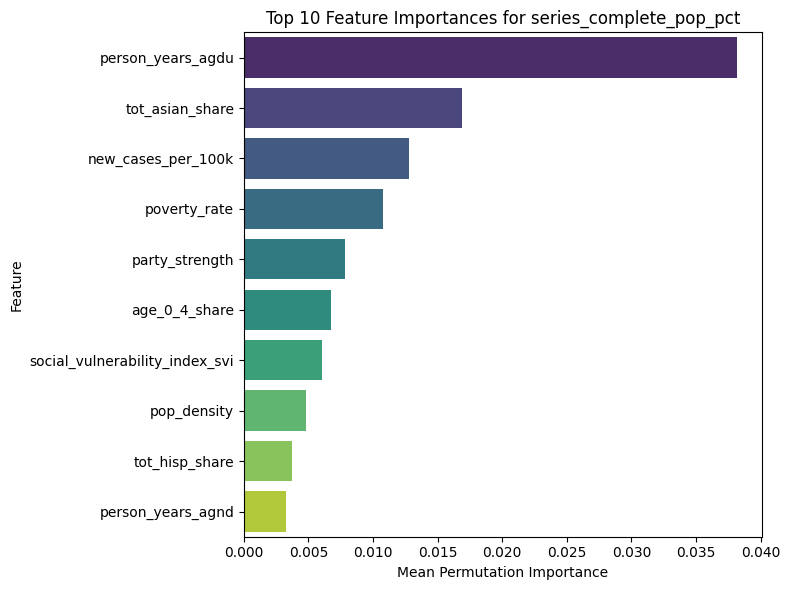

Analyzing outcome: series_complete_65pluspop_pct
Training R² score: 0.993
Test R² score    : 0.956
Test MSE         : 63.45
Top 10 features by permutation importance:
year_2023                         1.178827
year_2022                         1.122963
year_2021                         1.027894
new_cases_per_100k                0.139168
party_strength                    0.009932
person_years_agdu                 0.005939
social_vulnerability_index_svi    0.004535
person_years_agnd                 0.004459
tot_asian_share                   0.003163
tot_black_share                   0.002384
dtype: float64 



/tmp/ipython-input-8-812994265.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


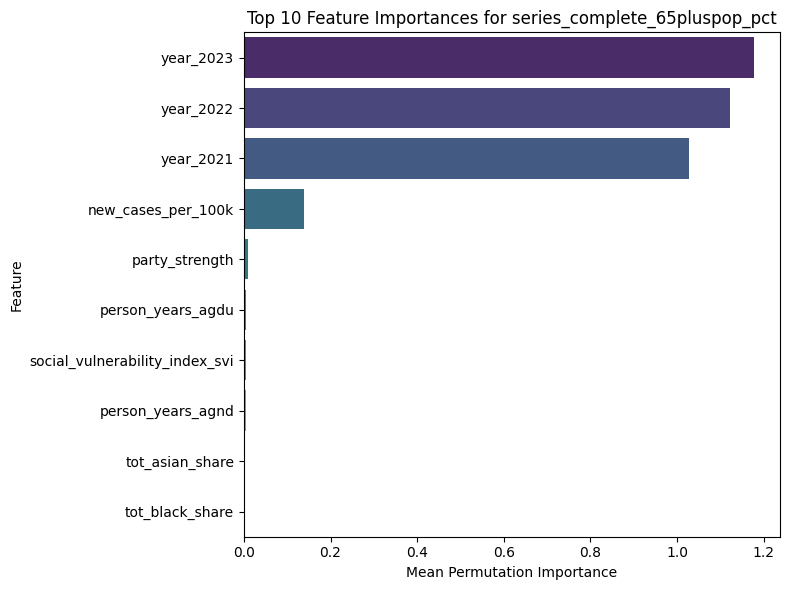

/tmp/ipython-input-8-812994265.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


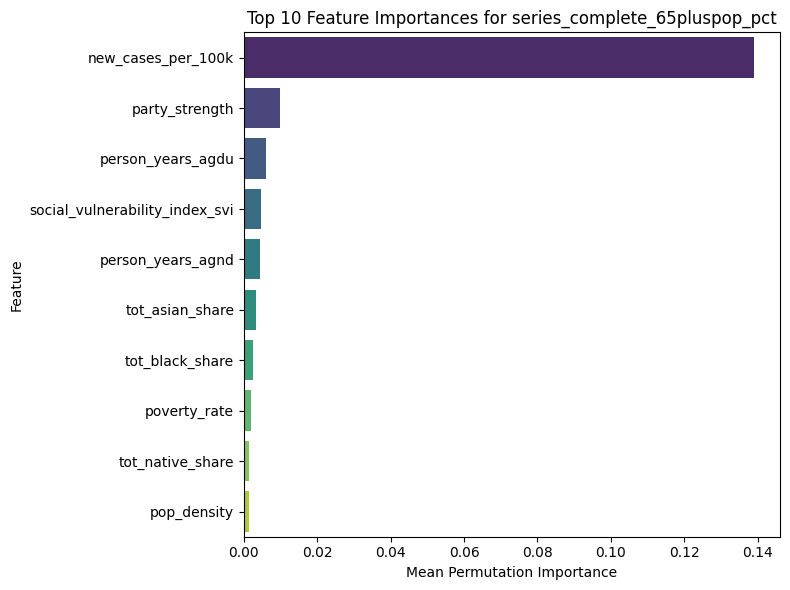

Analyzing outcome: mortality_rate_cfr
Training R² score: 0.935
Test R² score    : 0.561
Test MSE         : 0.29
Top 10 features by permutation importance:
tot_asian_share                   0.300457
new_cases_per_100k                0.138021
party_strength                    0.132771
social_vulnerability_index_svi    0.126865
age_20_49_share                   0.119805
year_2023                         0.086787
poverty_rate                      0.070099
person_years_agnd                 0.048450
person_years_esrd                 0.041148
pop_density                       0.038653
dtype: float64 



/tmp/ipython-input-8-812994265.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


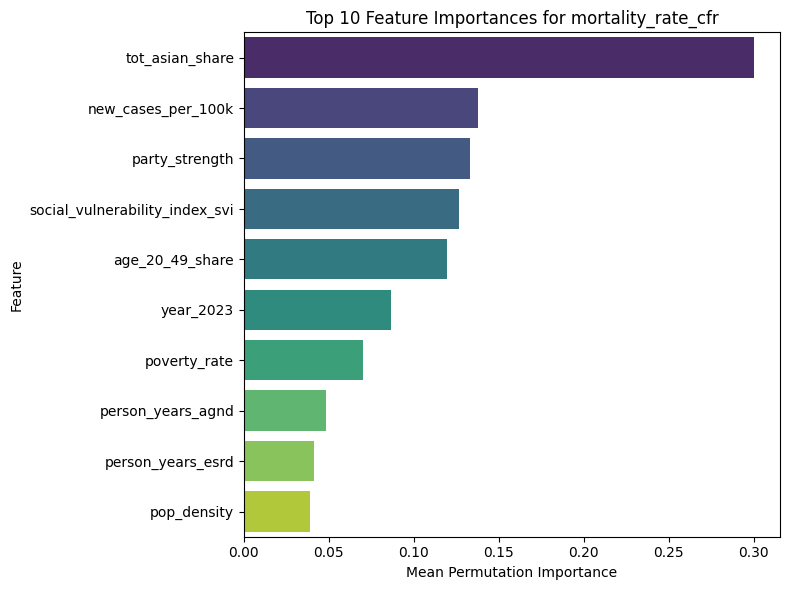

/tmp/ipython-input-8-812994265.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


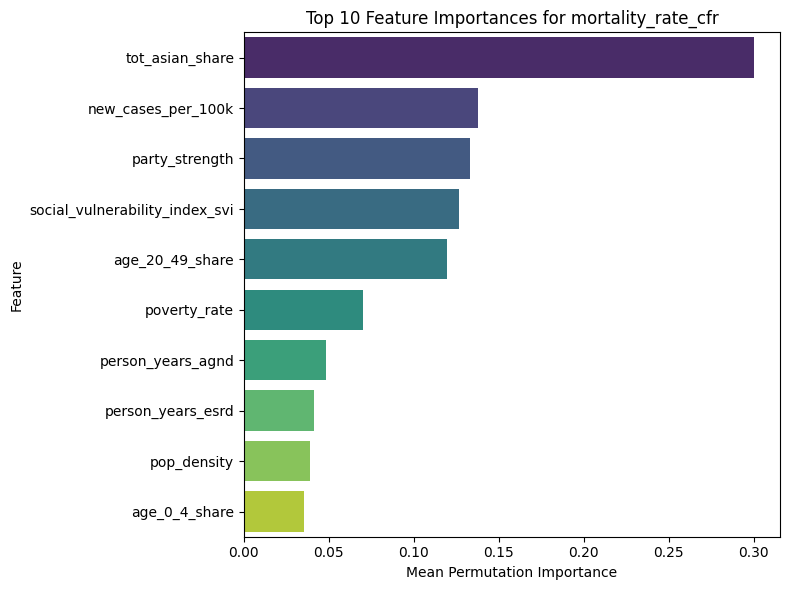

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

# Define your outcome and explanatory variables
outcome_vars = [
    "estimated_hesitant",
    "cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    #"cumulative_cases_per_100k",
    #"cumulative_deaths_per_100k"
    "mortality_rate_cfr"
]

explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
   #"tot_pop", "area",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    #"county_score",
    "rep_leaning", "party_strength", # political
    "poverty_rate", "social_vulnerability_index_svi",  # socio-economic
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",  # health
    "new_cases_per_100k",
]

# Create a dictionary to store importances
all_importances = {}

# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Step 1: Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    # Step 2: Coerce all columns to numeric
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Step 3: Drop rows with missing values
    df = df.dropna()

    # Step 4: Check for outcome variation
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Step 5: Split into X and y
    X = df[explanatory_vars]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)
    y = df[current_y]

    # Step 6: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 7: Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Step 8: Evaluate
    train_r2 = r2_score(y_train, rf.predict(X_train))
    test_r2 = r2_score(y_test, rf.predict(X_test))
    test_mse = mean_squared_error(y_test, rf.predict(X_test))

    print(f"Training R² score: {train_r2:.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")

    # Step 9: Permutation importance
    perm_result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    perm_importances = pd.Series(
        perm_result.importances_mean, index=X.columns
    ).sort_values(ascending=False)

    all_importances[current_y] = perm_importances



    print("Top 10 features by permutation importance:")
    print(perm_importances.head(10), "\n")

    # Step 10a: Plot top 10
    top_features = perm_importances.head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
    plt.title(f"Top 10 Feature Importances for {current_y}")
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Step 10b: Plot 10 top excluding year
    # Drop year dummy columns for plotting
    non_year_importances = perm_importances[~perm_importances.index.str.startswith("year_")]
    # Select top features excluding year dummies
    top_features = non_year_importances.head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
    plt.title(f"Top 10 Feature Importances for {current_y}")
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


Run code again + saving of plots

/tmp/ipython-input-9-3405775902.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=axs_all[i], palette="viridis")
/tmp/ipython-input-9-3405775902.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=axs_all[i], palette="viridis")
/tmp/ipython-input-9-3405775902.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=axs_all[i], palette="viridis")
/tmp/ipython-input-9-3405775902.py:84: FutureWarning: 


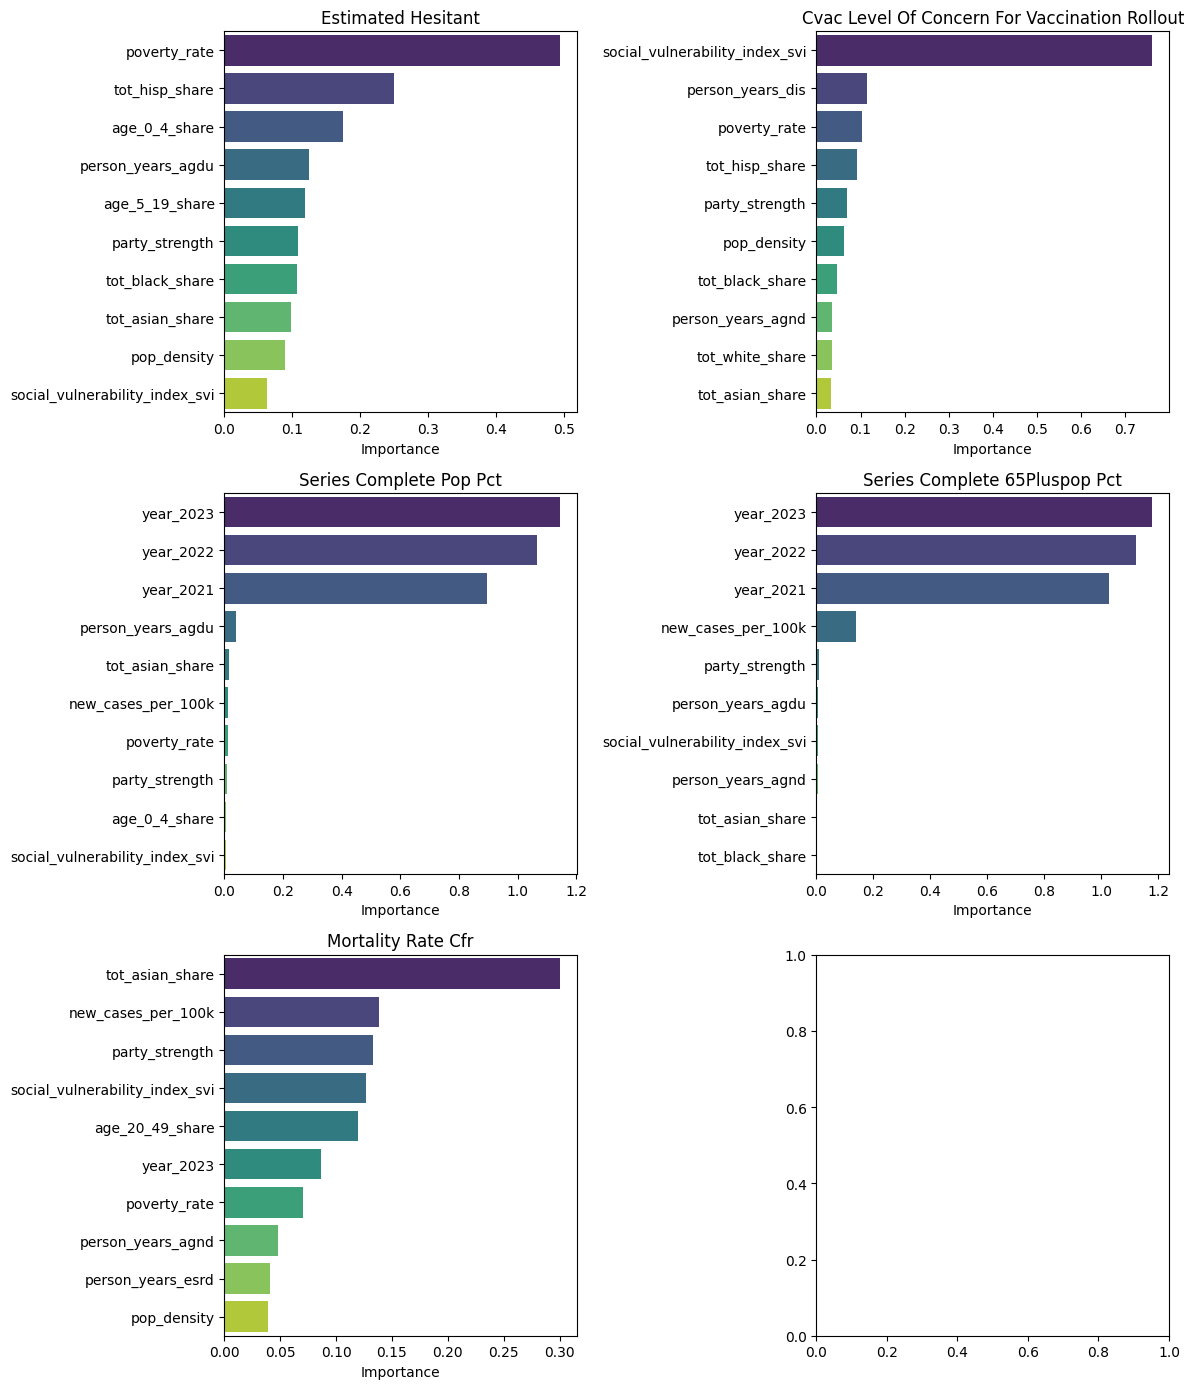

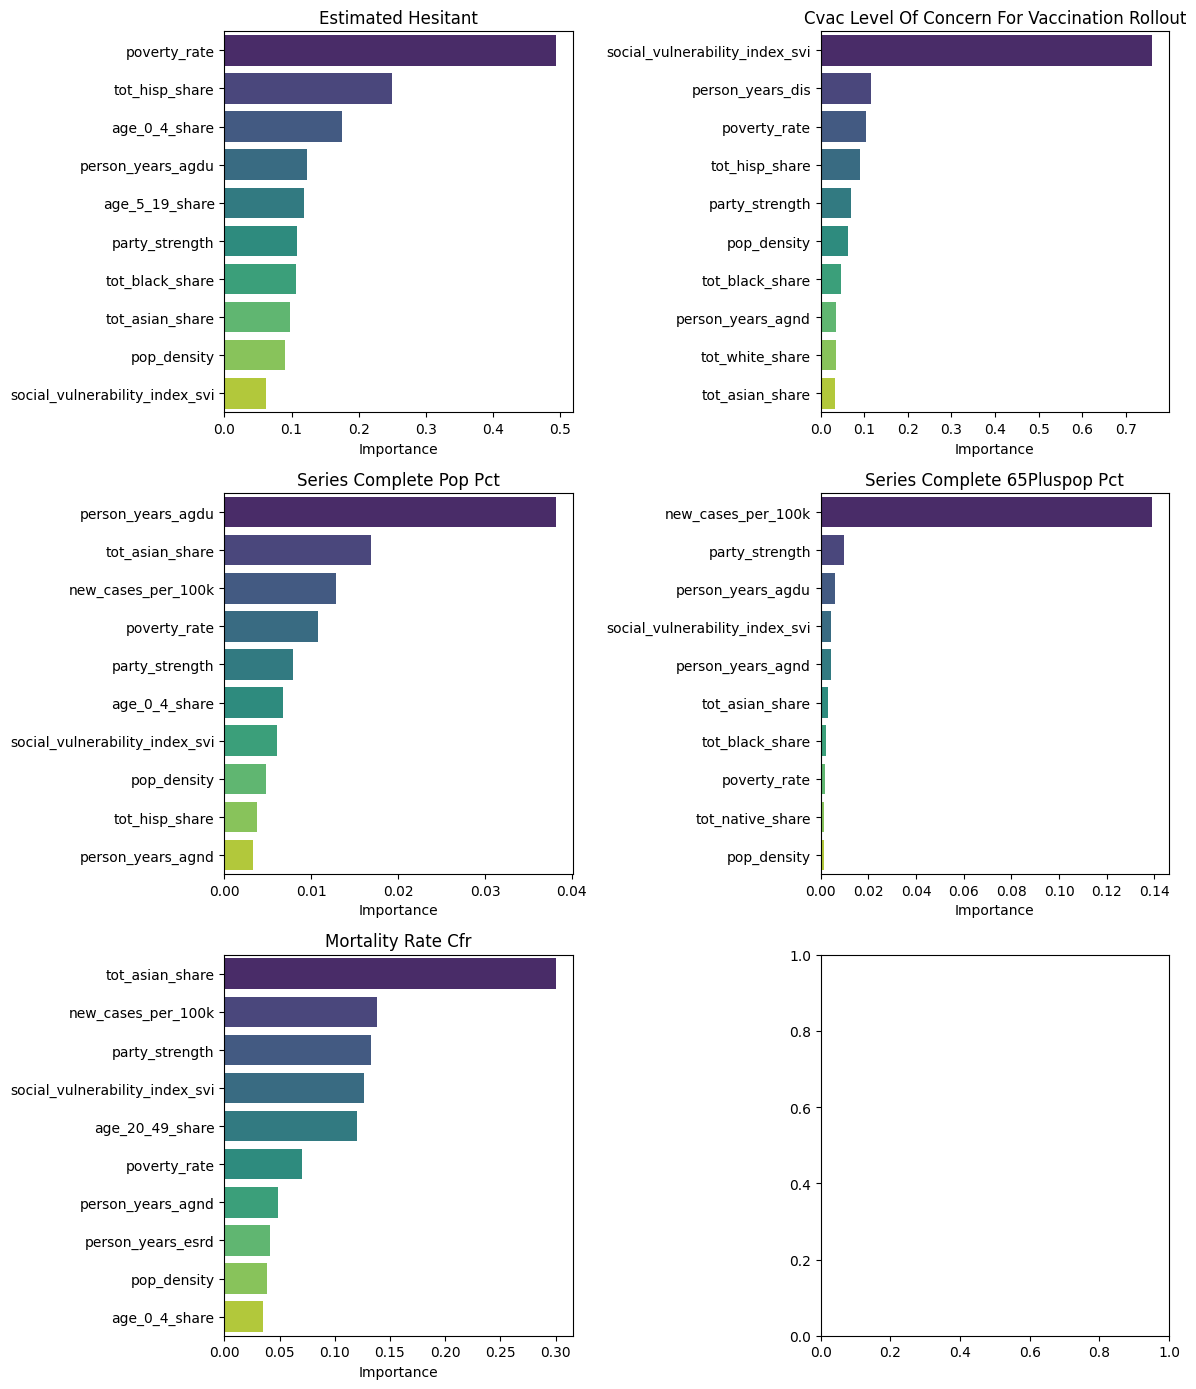

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error

# Assuming merged_df is already available in the environment

# Define outcome and explanatory variables
outcome_vars = [
    "estimated_hesitant",
    "cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]

explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    "rep_leaning", "party_strength",
    "poverty_rate", "social_vulnerability_index_svi",
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",
    "new_cases_per_100k",
]

# Create dictionaries to store importances
importances_all = {}
importances_no_year = {}

# Ensure output directories
os.makedirs("visuals", exist_ok=True)

# Loop over outcome variables
for current_y in outcome_vars:
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna()

    if df[current_y].nunique() <= 1:
        continue

    X = df[explanatory_vars]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)
    y = df[current_y]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    perm_result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )

    perm_importances = pd.Series(
        perm_result.importances_mean, index=X.columns
    ).sort_values(ascending=False)

    importances_all[current_y] = perm_importances
    importances_no_year[current_y] = perm_importances[~perm_importances.index.str.startswith("year_")]

# Plot grid: all variables
fig_all, axs_all = plt.subplots(3, 2, figsize=(12, 14))
axs_all = axs_all.flatten()

for i, current_y in enumerate(outcome_vars):
    top_features = importances_all[current_y].head(10)
    sns.barplot(x=top_features.values, y=top_features.index, ax=axs_all[i], palette="viridis")
    axs_all[i].set_title(f"{current_y.replace('_', ' ').title()}")
    axs_all[i].set_xlabel("Importance")
    axs_all[i].set_ylabel("")

plt.tight_layout()
fig_all.savefig("/content/drive/MyDrive/STATS-4241/grid_importance_all.png", dpi=300)

# Plot grid: without year
fig_noyear, axs_noyear = plt.subplots(3, 2, figsize=(12, 14))
axs_noyear = axs_noyear.flatten()

for i, current_y in enumerate(outcome_vars):
    top_features = importances_no_year[current_y].head(10)
    sns.barplot(x=top_features.values, y=top_features.index, ax=axs_noyear[i], palette="viridis")
    axs_noyear[i].set_title(f"{current_y.replace('_', ' ').title()}")
    axs_noyear[i].set_xlabel("Importance")
    axs_noyear[i].set_ylabel("")

plt.tight_layout()
fig_noyear.savefig("/content/drive/MyDrive/STATS-4241/grid_importance_no_year.png", dpi=300)



Adds tuning. Adds complexity but does not improve performance.

Analyzing outcome: estimated_hesitant
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Training R² score: 0.983
Test R² score    : 0.883
Test MSE         : 2.34


/tmp/ipython-input-10-497752280.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


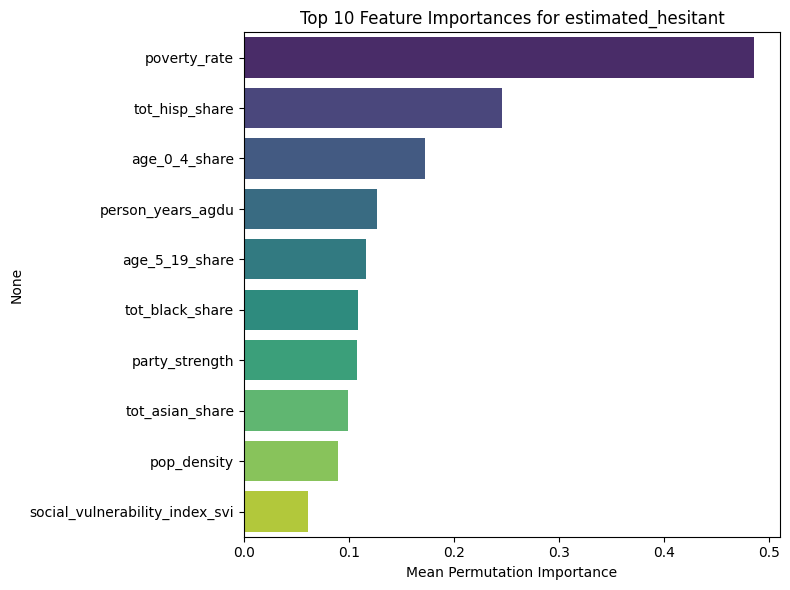

/tmp/ipython-input-10-497752280.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_no_year.values, y=top_features_no_year.index, palette="viridis")


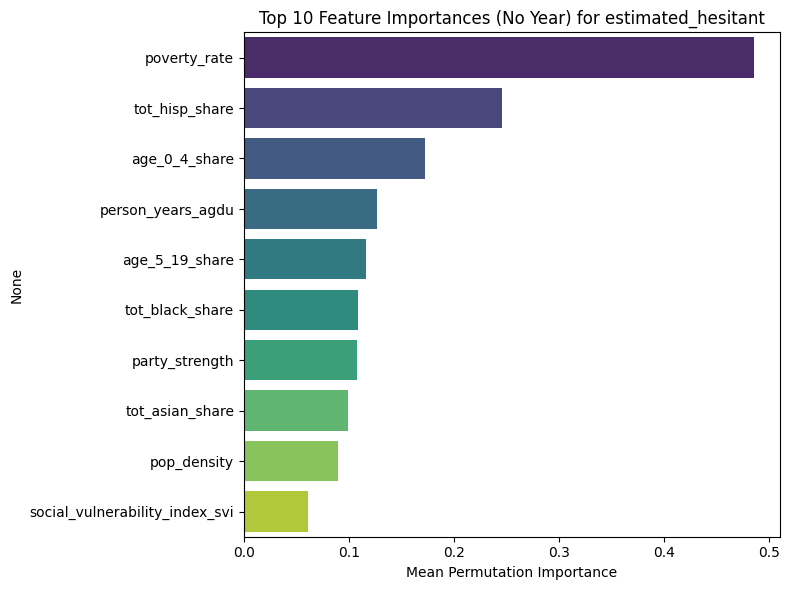

Analyzing outcome: cvac_level_of_concern_for_vaccination_rollout
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Training R² score: 0.988
Test R² score    : 0.917
Test MSE         : 70.22


/tmp/ipython-input-10-497752280.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


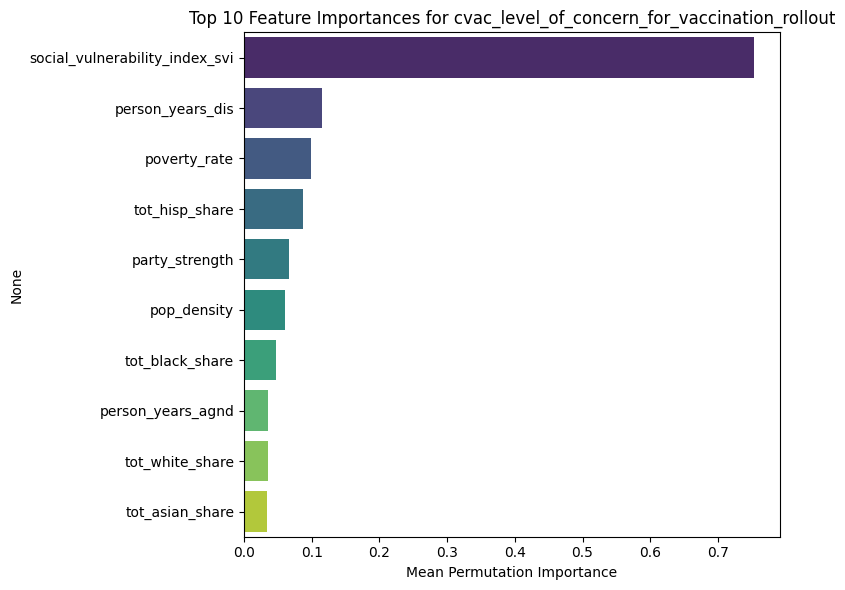

/tmp/ipython-input-10-497752280.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_no_year.values, y=top_features_no_year.index, palette="viridis")


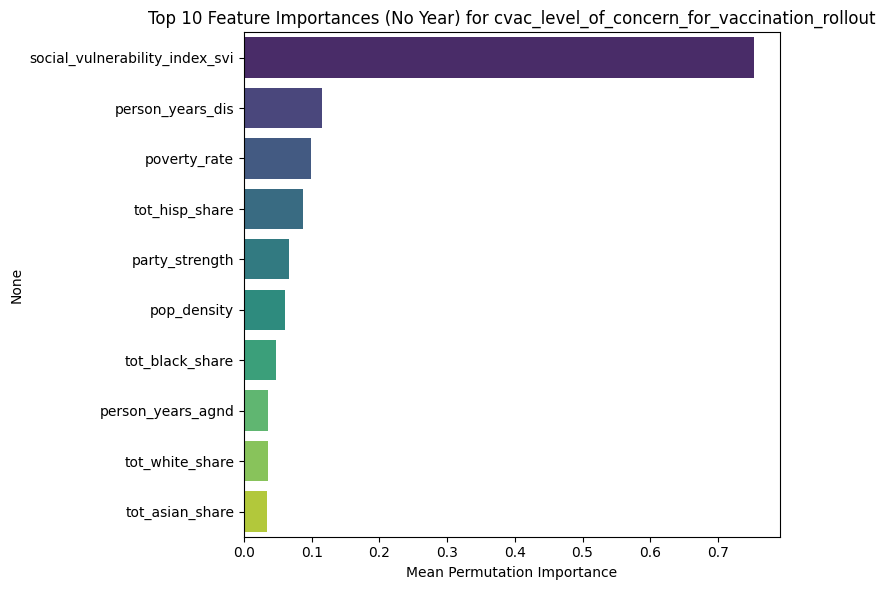

Analyzing outcome: series_complete_pop_pct
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Training R² score: 0.989
Test R² score    : 0.932
Test MSE         : 47.04


/tmp/ipython-input-10-497752280.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


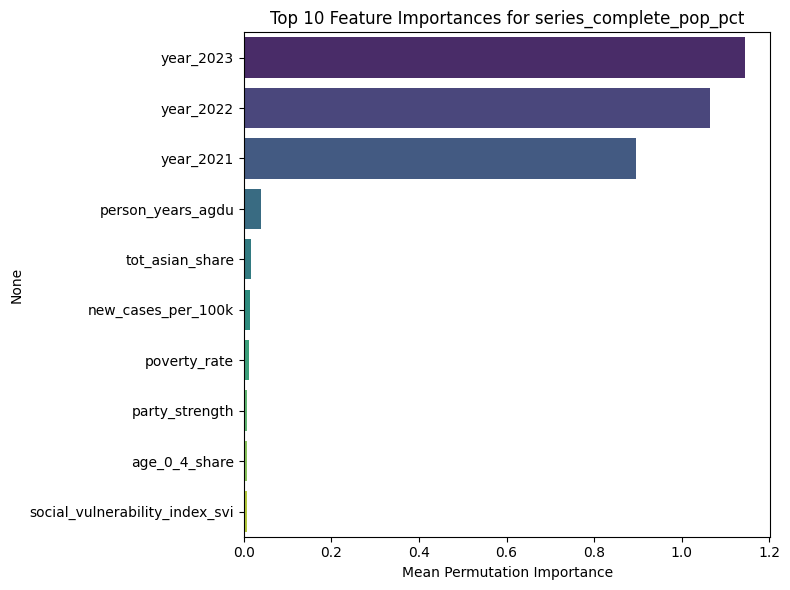

/tmp/ipython-input-10-497752280.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_no_year.values, y=top_features_no_year.index, palette="viridis")


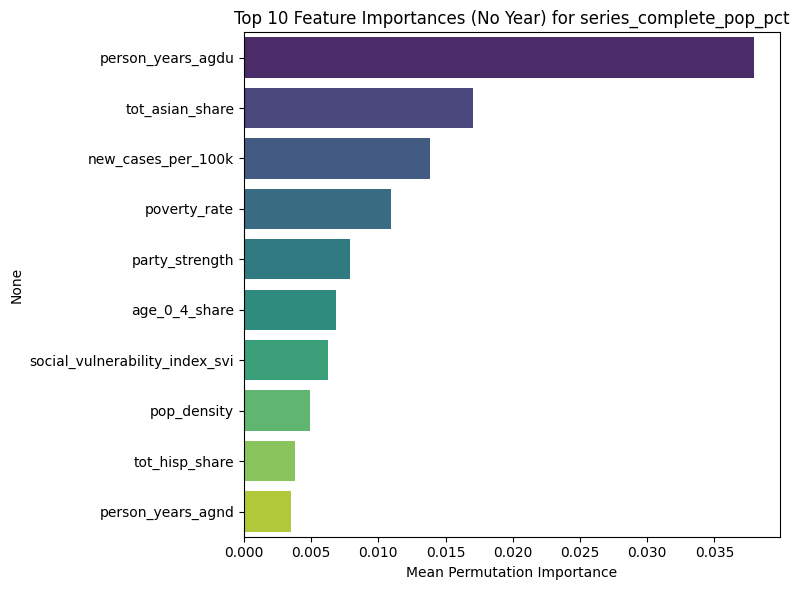

Analyzing outcome: series_complete_65pluspop_pct
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Training R² score: 0.991
Test R² score    : 0.957
Test MSE         : 62.59


/tmp/ipython-input-10-497752280.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


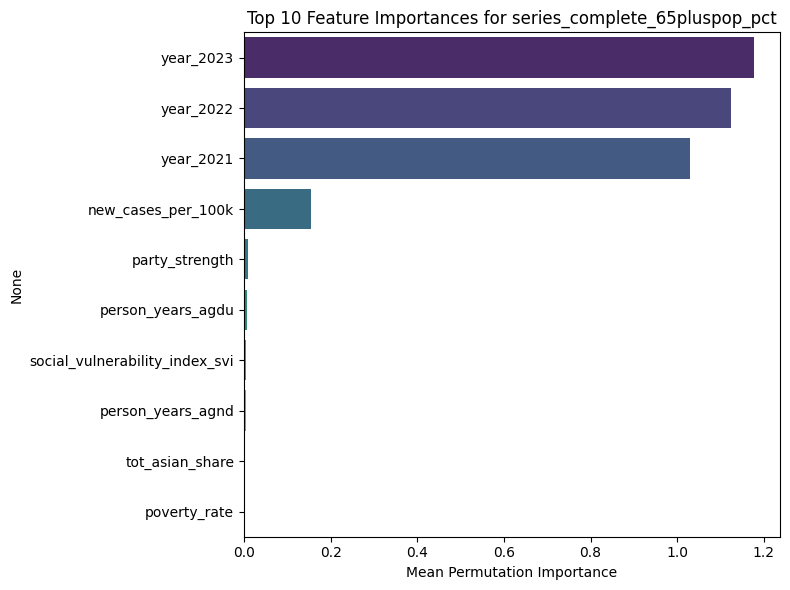

/tmp/ipython-input-10-497752280.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_no_year.values, y=top_features_no_year.index, palette="viridis")


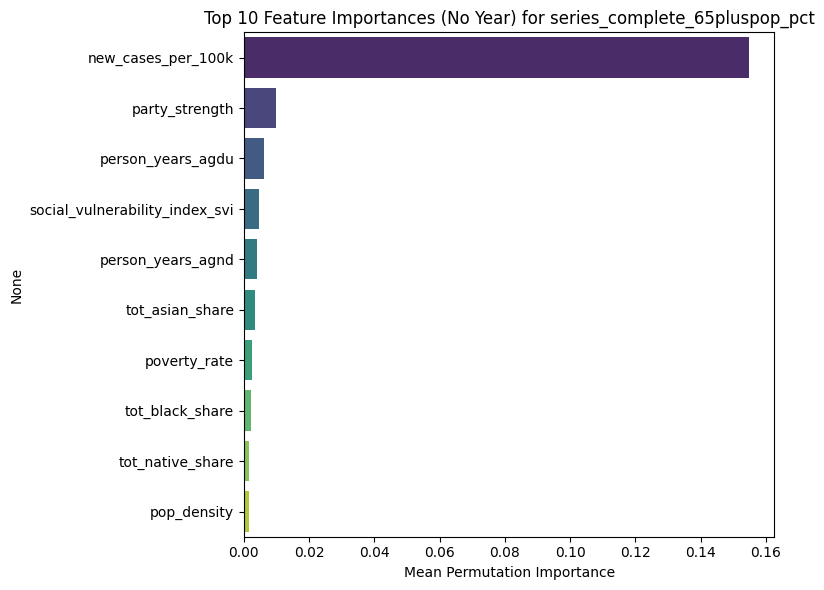

Analyzing outcome: mortality_rate_cfr
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Training R² score: 0.936
Test R² score    : 0.561
Test MSE         : 0.29


/tmp/ipython-input-10-497752280.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


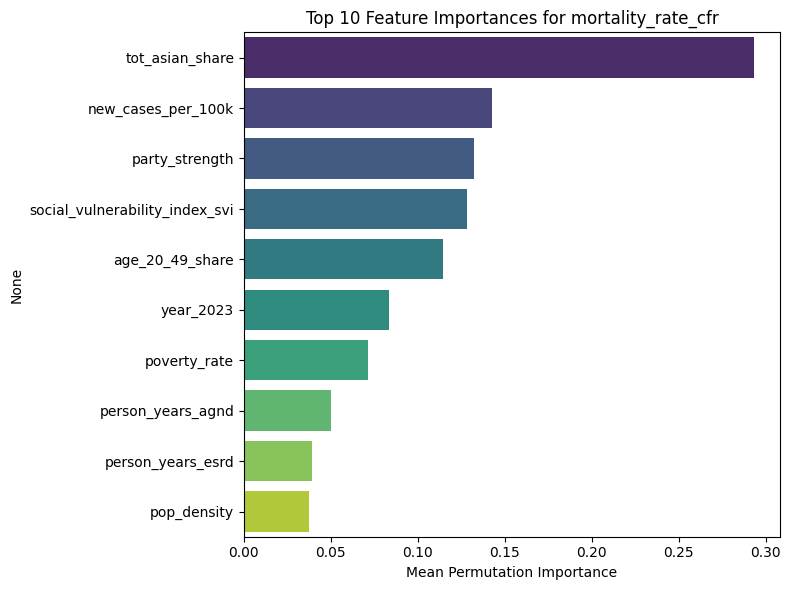

/tmp/ipython-input-10-497752280.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features_no_year.values, y=top_features_no_year.index, palette="viridis")


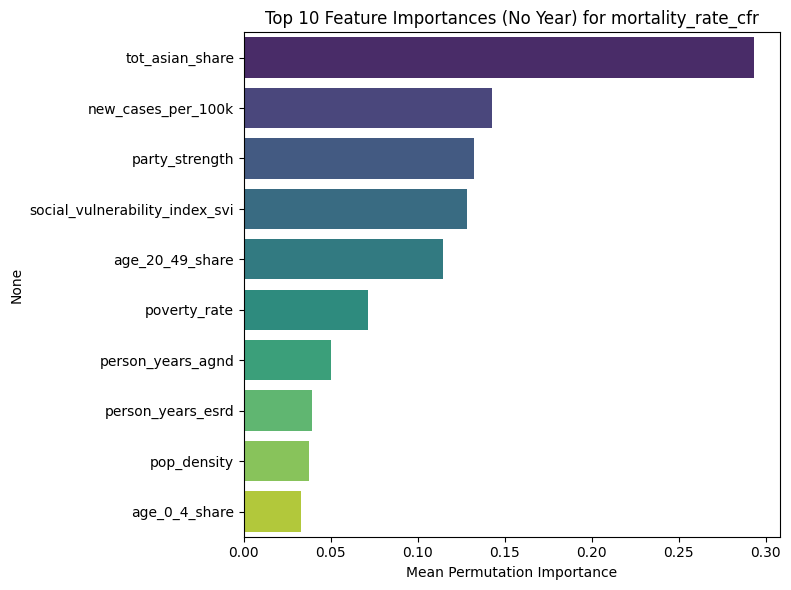

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

# Example dataset assumed to be present as 'merged_df'
# Define outcome and explanatory variables
outcome_vars = [
    "estimated_hesitant",
    "cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]

explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    "rep_leaning", "party_strength",
    "poverty_rate", "social_vulnerability_index_svi",
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",
    "new_cases_per_100k",
]

# Create a dictionary to store importances
all_importances = {}

# Placeholder for results
rf_results = {}

# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna()
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Split
    X = df[explanatory_vars]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)
    y = df[current_y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Grid search tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    rf = grid_search.best_estimator_

    # Evaluation
    train_r2 = r2_score(y_train, rf.predict(X_train))
    test_r2 = r2_score(y_test, rf.predict(X_test))
    test_mse = mean_squared_error(y_test, rf.predict(X_test))

    print(f"Best Params: {grid_search.best_params_}")
    print(f"Training R² score: {train_r2:.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")

    # Permutation importance
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_importances = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False)
    all_importances[current_y] = perm_importances

    # Plot Top 10 (all features)
    top_features = perm_importances.head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
    plt.title(f"Top 10 Feature Importances for {current_y}")
    plt.xlabel("Mean Permutation Importance")
    plt.tight_layout()
    plt.show()

    # Plot Top 10 (excluding year)
    non_year_importances = perm_importances[~perm_importances.index.str.startswith("year_")]
    top_features_no_year = non_year_importances.head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features_no_year.values, y=top_features_no_year.index, palette="viridis")
    plt.title(f"Top 10 Feature Importances (No Year) for {current_y}")
    plt.xlabel("Mean Permutation Importance")
    plt.tight_layout()
    plt.show()

    # Store performance and best parameters
    rf_results[current_y] = {
        "best_params": grid_search.best_params_,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "test_mse": test_mse
    }



#### Futher exploration: adding interaction explicitly

We add an interaction to see whether the effect of party strength differs by party and whether it is selected as an important feature

Analyzing outcome: estimated_hesitant
Training R² score: 0.982
Test R² score    : 0.883
Test MSE         : 2.34
Top 10 features by permutation importance:
poverty_rate                      0.490703
tot_hisp_share                    0.241698
age_0_4_share                     0.172378
person_years_agdu                 0.124196
age_5_19_share                    0.118743
party_strength                    0.104371
tot_black_share                   0.102273
tot_asian_share                   0.101813
pop_density                       0.088607
social_vulnerability_index_svi    0.063602
dtype: float64 



/tmp/ipython-input-11-2957103175.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


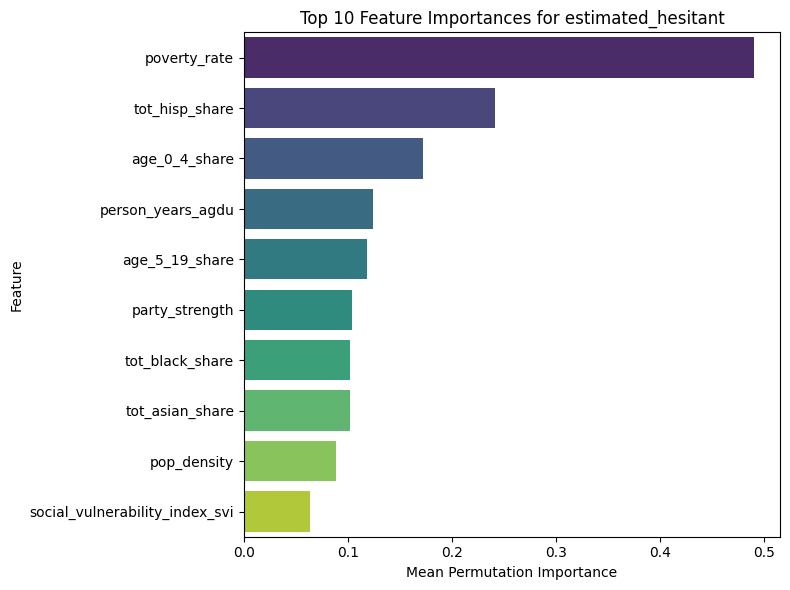

Analyzing outcome: cvac_level_of_concern_for_vaccination_rollout
Training R² score: 0.988
Test R² score    : 0.922
Test MSE         : 65.69
Top 10 features by permutation importance:
social_vulnerability_index_svi    0.761875
person_years_dis                  0.117711
poverty_rate                      0.102919
tot_hisp_share                    0.084737
party_strength                    0.067598
pop_density                       0.055991
tot_black_share                   0.044822
person_years_agnd                 0.034499
tot_native_share                  0.032127
tot_white_share                   0.031040
dtype: float64 



/tmp/ipython-input-11-2957103175.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


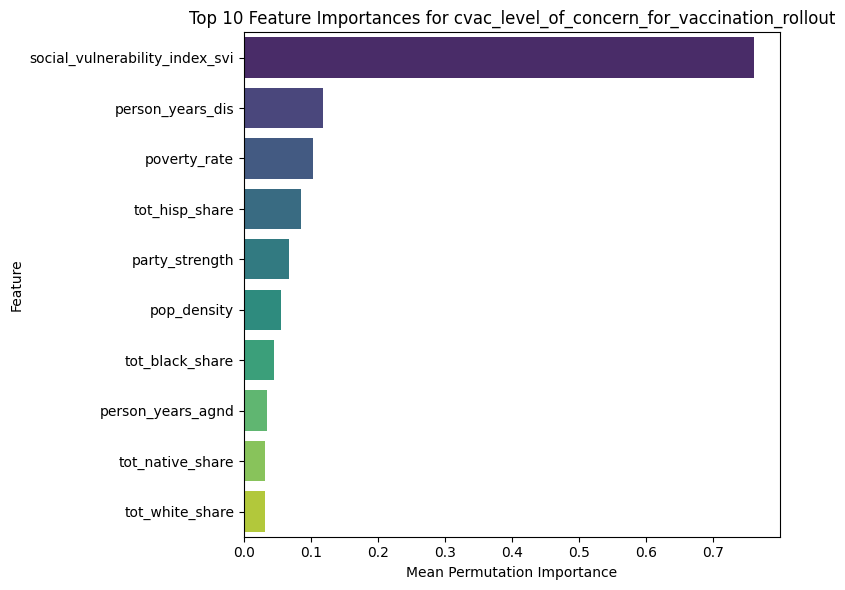

Analyzing outcome: series_complete_pop_pct
Training R² score: 0.989
Test R² score    : 0.932
Test MSE         : 47.46
Top 10 features by permutation importance:
year_2023                         1.144546
year_2022                         1.066266
year_2021                         0.895679
person_years_agdu                 0.038439
tot_asian_share                   0.016470
new_cases_per_100k                0.013791
poverty_rate                      0.010753
party_strength                    0.007676
age_0_4_share                     0.006752
social_vulnerability_index_svi    0.006201
dtype: float64 



/tmp/ipython-input-11-2957103175.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


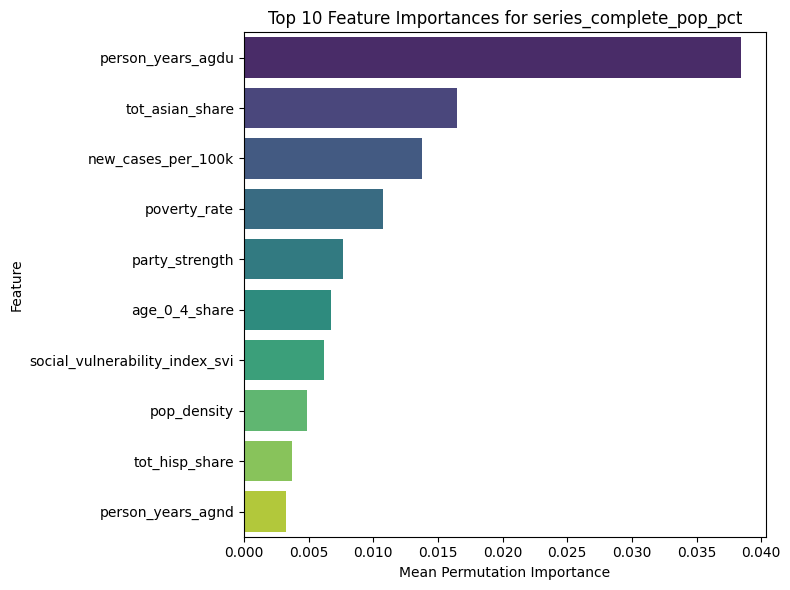

Analyzing outcome: series_complete_65pluspop_pct
Training R² score: 0.993
Test R² score    : 0.956
Test MSE         : 63.48
Top 10 features by permutation importance:
year_2023                         1.178577
year_2022                         1.123104
year_2021                         1.028507
new_cases_per_100k                0.138778
party_strength                    0.009773
person_years_agdu                 0.006123
person_years_agnd                 0.004590
social_vulnerability_index_svi    0.004441
tot_asian_share                   0.003059
tot_black_share                   0.002277
dtype: float64 



/tmp/ipython-input-11-2957103175.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


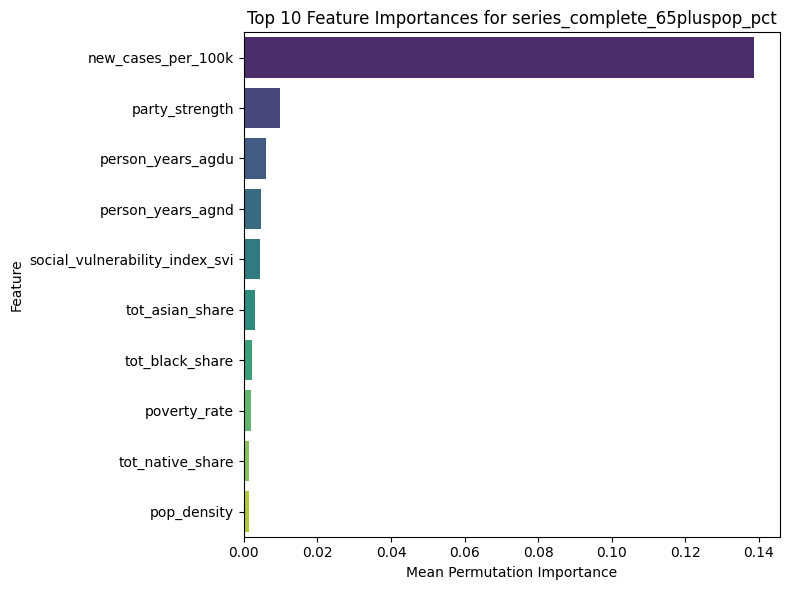

Analyzing outcome: mortality_rate_cfr
Training R² score: 0.935
Test R² score    : 0.564
Test MSE         : 0.29
Top 10 features by permutation importance:
tot_asian_share                   0.295579
new_cases_per_100k                0.138513
party_strength                    0.135973
social_vulnerability_index_svi    0.125362
age_20_49_share                   0.122153
year_2023                         0.086309
poverty_rate                      0.072877
person_years_agnd                 0.050648
person_years_esrd                 0.040328
age_0_4_share                     0.037588
dtype: float64 



/tmp/ipython-input-11-2957103175.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


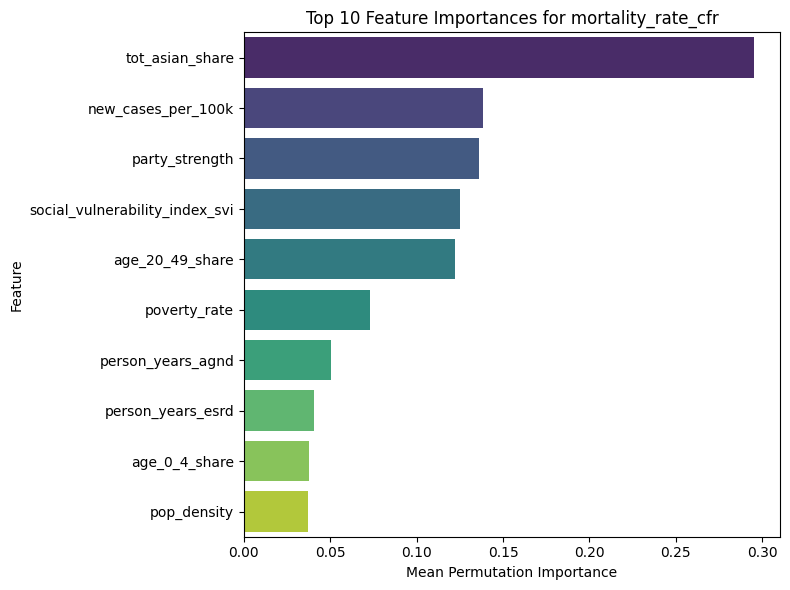

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

# Define outcome and explanatory variables
outcome_vars = [
    "estimated_hesitant",
    "cvac_level_of_concern_for_vaccination_rollout",
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]

explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    #"tot_pop", "area",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    #"county_score",
    "rep_leaning", "party_strength", # political
    "poverty_rate", "social_vulnerability_index_svi",  # socio-economic
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",  # health
    "new_cases_per_100k"
]


# Create a dictionary to store importances
all_importances = {}

# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Step 1: Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    # Step 2: Coerce all columns to numeric
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Step 3: Drop rows with missing values
    df = df.dropna()

    # Step 4: Check for outcome variation
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Step 5: Split into X and y
    X = df[explanatory_vars]
    X["rep_strength_interaction"] = X["rep_leaning"] * X["party_strength"]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)
    y = df[current_y]

    # Step 6: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 7: Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Step 8: Evaluate
    train_r2 = r2_score(y_train, rf.predict(X_train))
    test_r2 = r2_score(y_test, rf.predict(X_test))
    test_mse = mean_squared_error(y_test, rf.predict(X_test))

    print(f"Training R² score: {train_r2:.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")

    # Step 9: Permutation importance
    perm_result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    perm_importances = pd.Series(
        perm_result.importances_mean, index=X.columns
    ).sort_values(ascending=False)

    all_importances[current_y] = perm_importances

    print("Top 10 features by permutation importance:")
    print(perm_importances.head(10), "\n")

     # Drop year dummy columns for plotting
    non_year_importances = perm_importances[~perm_importances.index.str.startswith("year_")]
    # Select top features excluding year dummies
    top_features = non_year_importances.head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
    plt.title(f"Top 10 Feature Importances for {current_y}")
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

We suspect the role of political leaning for Covid outcomes might change throughout the years

Analyzing outcome: series_complete_pop_pct
Training R² score: 0.989
Test R² score    : 0.931
Test MSE         : 47.85
Top 10 features by permutation importance:
year_2023                         1.145242
year_2022                         1.065980
year_2021                         0.895144
person_years_agdu                 0.037634
tot_asian_share                   0.017179
new_cases_per_100k                0.013833
poverty_rate                      0.010509
party_strength                    0.007823
age_0_4_share                     0.006672
social_vulnerability_index_svi    0.005876
dtype: float64 



/tmp/ipython-input-12-3450609131.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


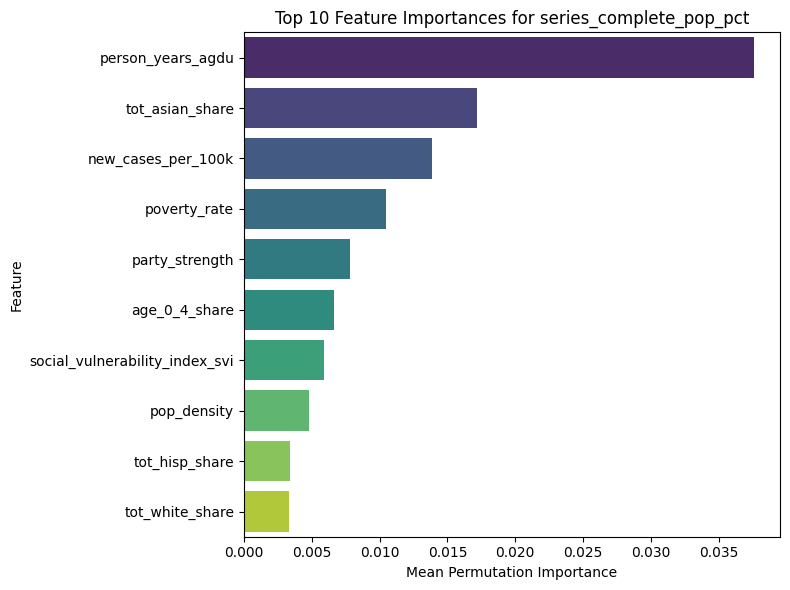

Analyzing outcome: series_complete_65pluspop_pct
Training R² score: 0.993
Test R² score    : 0.956
Test MSE         : 63.57
Top 10 features by permutation importance:
year_2023                         1.178174
year_2022                         1.122592
year_2021                         1.028344
new_cases_per_100k                0.138737
party_strength                    0.009739
person_years_agdu                 0.006043
social_vulnerability_index_svi    0.004363
person_years_agnd                 0.004349
tot_asian_share                   0.003189
tot_black_share                   0.002155
dtype: float64 



/tmp/ipython-input-12-3450609131.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


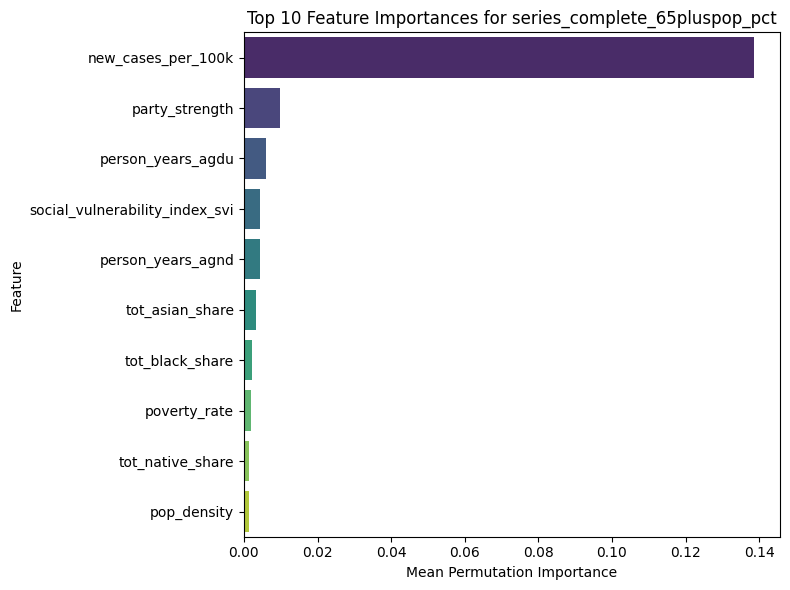

Analyzing outcome: mortality_rate_cfr
Training R² score: 0.935
Test R² score    : 0.562
Test MSE         : 0.29
Top 10 features by permutation importance:
tot_asian_share                   0.299009
new_cases_per_100k                0.137051
party_strength                    0.134229
social_vulnerability_index_svi    0.128534
age_20_49_share                   0.118991
year_2023                         0.085312
poverty_rate                      0.072038
person_years_agnd                 0.049084
person_years_esrd                 0.040796
age_0_4_share                     0.037460
dtype: float64 



/tmp/ipython-input-12-3450609131.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


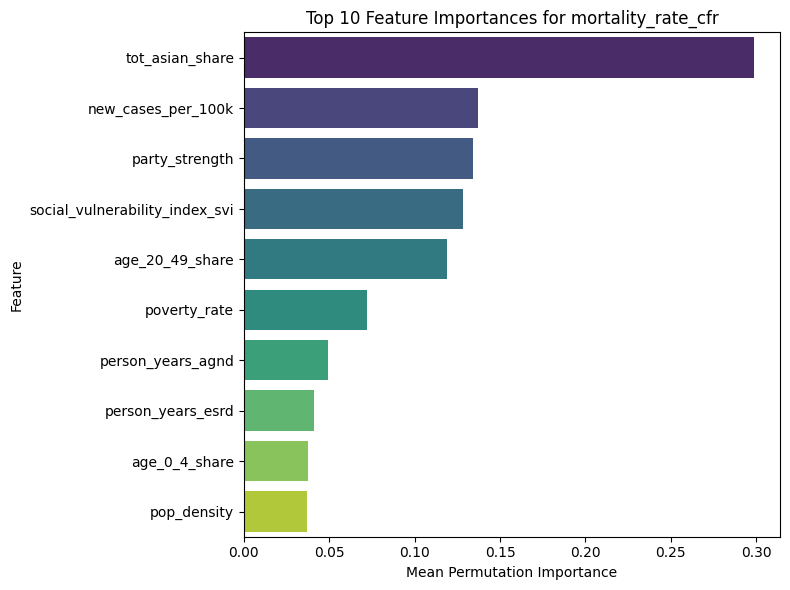

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

# Define your outcome and explanatory variables
outcome_vars = [
    "series_complete_pop_pct",
    "series_complete_65pluspop_pct",
    "mortality_rate_cfr"
]

explanatory_vars = [
    "year",
    "age_0_4_share", "age_5_19_share", "age_20_49_share",
    "age_50_64_share", "age_65__share",
    #"tot_pop", "area",
    "pop_density",
    "tot_male_share", "tot_female_share",
    "tot_white_share", "tot_black_share",
    "tot_asian_share", "tot_native_share", "tot_hisp_share",
    #"county_score",
    "rep_leaning", "party_strength", # political
    "poverty_rate", "social_vulnerability_index_svi",  # socio-economic
    "person_years_esrd", "person_years_dis",
    "person_years_agdu", "person_years_agnd",  # health
    "new_cases_per_100k"
]


# Create a dictionary to store importances
all_importances = {}

# Loop over outcome variables
for current_y in outcome_vars:
    print("=" * 70)
    print(f"Analyzing outcome: {current_y}")

    # Step 1: Prepare data
    cols_needed = explanatory_vars + [current_y]
    df = merged_df[cols_needed].copy()

    # Step 2: Coerce all columns to numeric
    for col in cols_needed:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Step 3: Drop rows with missing values
    df = df.dropna()

    # Step 4: Check for outcome variation
    if df[current_y].nunique() <= 1:
        print(f"Outcome '{current_y}' has no variation. Skipping.\n")
        continue

    # Step 5: Split into X and y
    X = df[explanatory_vars]
    #X["rep_strength_interaction"] = X["rep_leaning"] * X["party_strength"]
    X = pd.get_dummies(X, columns=["year"], drop_first=True)

    for col in X.columns:
      if col.startswith("year_"):
        X[f"rep_leaning_{col}"] = X["rep_leaning"] * X[col]


    y = df[current_y]

    # Step 6: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 7: Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Step 8: Evaluate
    train_r2 = r2_score(y_train, rf.predict(X_train))
    test_r2 = r2_score(y_test, rf.predict(X_test))
    test_mse = mean_squared_error(y_test, rf.predict(X_test))

    print(f"Training R² score: {train_r2:.3f}")
    print(f"Test R² score    : {test_r2:.3f}")
    print(f"Test MSE         : {test_mse:.2f}")

    # Step 9: Permutation importance
    perm_result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    perm_importances = pd.Series(
        perm_result.importances_mean, index=X.columns
    ).sort_values(ascending=False)

    all_importances[current_y] = perm_importances

    print("Top 10 features by permutation importance:")
    print(perm_importances.head(10), "\n")

      # Drop year dummy columns for plotting
    non_year_importances = perm_importances[~perm_importances.index.str.startswith("year_")]
    # Select top features excluding year dummies
    top_features = non_year_importances.head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
    plt.title(f"Top 10 Feature Importances for {current_y}")
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()